## Load required packages

In [1]:
import sys
sys.path.append("/home/dquevedo/AMBRS/ambrs/ambrs") # include path where AMBRS is installed locally
import os
import copy
import json
import ambrs
import numpy as np
import scipy.stats as stats
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

## Define gas and aerosol species

In [2]:
# List SOAG species to filter from GC namelist
soa_defn = pd.read_csv('/home/dquevedo/AMBRS/jupyter_notebooks/soa_defn.csv')
soag_species = soa_defn.loc[soa_defn['POA'].str.strip()=='F','Vapor Name'].str.strip(" '")
soag_species.loc[soa_defn['Rxn Cntr Name'].str.strip(" '").str.len() > 0] = soa_defn.loc[soa_defn['Rxn Cntr Name'].str.strip(" '").str.len() > 0,'Rxn Cntr Name'].str.strip(" '")
soag_species = list(soag_species)

In [3]:
# Read AE species JSON from CAMP definitions
with open('/home/dquevedo/AMBRS/ambrs_mam4_cb6r5_ae7_aq/tests/ae_species.json') as f:
    ae = json.load(f)['camp-data']
f.close()
# Read GC species JSON from CAMP definitions
with open('/home/dquevedo/AMBRS/ambrs_mam4_cb6r5_ae7_aq/tests/gc_species.json') as f:
    gc = json.load(f)['camp-data']
f.close()
# Read CAMP JSON for other species (those not from cb6r5_ae7_aq namelist)
with open('/home/dquevedo/AMBRS/ambrs_mam4_cb6r5_ae7_aq/tests/other.json') as f:
    othr = json.load(f)['camp-data']
f.close()

In [4]:
# List particulate species of interest
particulate_species = [ # CB6 analogs for MAM4 species
    'ASO4', # Particulate sulfate
    'AH2O', # Aerosol-phase water
    'AH3OP', # Hydronium ion; for CAMP sulfate condensation
    'HSO4_aq', # Aqueous bisulfate; for CAMP sulfate condensation
    'H2SO4_aq', # Aqueous sulfuric acid; for CAMP sulfate condensation
    'SOA', # Secondary organic aerosol
    'APOC', # Primary organic carbon
    'ANA', # Sodium ion
    'ASOIL', # Dust aerosol?
    'AEC', # Elemental carbon
]

aliases = [ # MAM4 equivalent names for CB6 species
    'SO4',
    'H2O',
    None,
    None,
    None,
    'SOA',
    'POM',
    'NCL',
    'DST',
    'BC',
]
alias_dict = {p: a for p, a in zip(particulate_species, aliases)}

In [5]:
# Define AMBRS aerosol species
# Pull aerosol species from JSON based on AE namelist
particles = [
    ambrs.AerosolSpecies(
        name = f'{p['name']}',
        molar_mass = 1.e3 * p['molecular weight [kg mol-1]'], # Convert molecular mass [kg/mol] to molar mass [g/mol]
        density = p['density [kg m-3]'],
        ions_in_soln = p['num_ions'],
        hygroscopicity = p['kappa'],
        aliases = alias_dict[p['name']]
    ) for p in ae if p['name'] in particulate_species # include AE namelist particles if they are listed in paritulcate_species
]
# Pull aerosol species from other species JSON
for p in othr:
    if 'phase' in p and p['name'] in particulate_species: # check for 'phase' because gas-phase species do not explicitly define a phase attribute
        particles.append(
            ambrs.AerosolSpecies(
                name = f'{p['name']}',
                molar_mass = 1.e3 * p['molecular weight [kg mol-1]'], # Convert molecular mass [kg/mol] to molar mass [g/mol]
                density = p['density [kg m-3]'],
                ions_in_soln = p['num_ions'],
                hygroscopicity = p['kappa'],
                aliases = alias_dict[p['name']]
            )
        )

# Define AMBRS gas species
gases = [
    ambrs.GasSpecies(
        name = g['name'],
        molar_mass = 1.e3 * g['molecular weight [kg mol-1]'] # Convert molecular mass [kg/mol] to molar mass [g/mol]
    ) for g in gc if g['name'] not in soag_species ] # only include gases that do not contribute to organic vapors
# Include lumped organic vapor
gases.append(
    ambrs.GasSpecies(
        name = 'SOAG',
        molar_mass = 12.011
    )
)

## Define initial conditions

In [6]:
# Read initial conditions data
with open('/home/dquevedo/AMBRS/ambrs_mam4_cb6r5_ae7_aq/tests/ic_sulfate_condensation.dat', 'r') as f:
    ics = [line.split(',') for line in f.readlines()[1::2]]
f.close()
# Pair initial conditions values with species name: (species, value)
ic_list = [(ic[0].strip(), ic[1].strip()) for ic in ics]

# Set initial aerosol masses if aerosol species is of interest
aero_masses = {ic[0]: float(ic[1]) for ic in ic_list if ic[0] in [p.name for p in particles]}

# Set initial gas mixing ratios
gas_ratios = {ic[0]: float(ic[1]) for ic in ic_list if ic[0] in [g.name for g in gases]}

In [7]:
# Reorder particles lists to match ordering of initial conditions
ordered_gases = []
ordered_particles = []
for ic in ic_list:
    for g in gases:
        if g.name == ic[0]:
            ordered_gases.append(g)
    for p in particles:
        if p.name == ic[0]:
            ordered_particles.append(p)

## Define ensemble

In [8]:
# aerosol processes to include
processes = ambrs.AerosolProcesses(
    gas_phase_chemistry = True,
    coagulation = True,
    condensation = False,
    nucleation = False
)

# Simulation parameters
dt = 60. # time step [s]
nstep = 60 # number of steps

# reference pressure and height
p0 = 101325. # [Pa]
h0 = 500.    # [m]

In [9]:
# Define constant "random variable" to fix parameters if perturbation is not desired
class const(stats.rv_continuous):
    def __init__(self, c):
        self.c = c
        self.a = c
        self.b = c
        self.loc = 0.
        self.scale = 1.
        self.badvalue = np.nan
    def _parse_args(self, *args, **kwds):
        return args, self.loc, self.scale
    def _ppf(self, q):
        return self.c

In [10]:
# Ensemble specification
# Based on MAM4 representation
mam4_spec = ambrs.EnsembleSpecification(
    name = "mam4",
    aerosols = tuple(ordered_particles),
    gases = tuple(ordered_gases),
    size = ambrs.AerosolModalSizeDistribution(
        modes = [
            ambrs.AerosolModeDistribution(
                name = "accumulation",
                species = ordered_particles,
                number = const(1.e8),
                geom_mean_diam = const(0.20e-6),
                log10_geom_std_dev = np.log10(1.8),
                mass_fractions = [const(aero_masses[p.name]) for p in ordered_particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "aitken",
                species = ordered_particles,
                number = const(1.e9),
                geom_mean_diam = const(0.04e-6),
                log10_geom_std_dev = np.log10(1.6),
                mass_fractions = [const(aero_masses[p.name]) if p.name in ['ASO4','AH2O','AH3OP','SOA','ANA'] else const(0.) for p in ordered_particles],
            ),
            ambrs.AerosolModeDistribution(
                name = "coarse",
                species = ordered_particles,
                number = const(1.e5),
                geom_mean_diam = const(2.00e-6),
                log10_geom_std_dev = np.log10(1.8),
                mass_fractions = [const(aero_masses[p.name]) for p in ordered_particles],
            ),
            ambrs.AerosolModeDistribution(
                name = "primary_carbon",
                species = ordered_particles,
                number = const(1.e8),
                geom_mean_diam = const(0.08e-6),
                log10_geom_std_dev = np.log10(1.6),
                mass_fractions = [const(aero_masses[p.name]) if p.name in ['APOC','AEC','AH2O','AH3OP'] else const(0.) for p in ordered_particles],
            ),
        ]
    ),
    gas_concs = tuple([const(gas_ratios[g.name]) for g in ordered_gases]),
    flux = const(0.),
    relative_humidity = const(0.9),
    temperature = stats.uniform(288.,10.), 
    pressure = p0,
    height = h0,
)

In [11]:
# Ensemble specification
# Based on PartMC representation

pmc_particles = copy.deepcopy(ordered_particles)
for p in pmc_particles:
    p.name = f'core.mixed.{p.name}' # Prepending PartMC nomenclature

pmc_spec = ambrs.EnsembleSpecification(
    name = "partmc",
    aerosols = tuple(pmc_particles),
    gases = tuple(ordered_gases),
    size = ambrs.AerosolModalSizeDistribution(
        modes = [
            ambrs.AerosolModeDistribution(
                name = "accumulation",
                species = pmc_particles,
                number = const(1.e8),
                geom_mean_diam = const(0.20e-6),
                log10_geom_std_dev = np.log10(1.8),
                mass_fractions = [const(aero_masses[p.name]) for p in ordered_particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "aitken",
                species = pmc_particles,
                number = const(1.e9),
                geom_mean_diam = const(0.04e-6),
                log10_geom_std_dev = np.log10(1.6),
                mass_fractions = [const(aero_masses[p.name]) if p.name in ['ASO4','AH2O','AH3OP','SOA','ANA'] else const(0.) for p in ordered_particles],
            ),
            ambrs.AerosolModeDistribution(
                name = "coarse",
                species = pmc_particles,
                number = const(1.e5),
                geom_mean_diam = const(2.00e-6),
                log10_geom_std_dev = np.log10(1.8),
                mass_fractions = [const(aero_masses[p.name]) for p in ordered_particles],
            ),
            ambrs.AerosolModeDistribution(
                name = "primary_carbon",
                species = pmc_particles,
                number = const(1.e8),
                geom_mean_diam = const(0.08e-6),
                log10_geom_std_dev = np.log10(1.6),
                mass_fractions = [const(aero_masses[p.name]) if p.name in ['APOC','AEC','AH2O','AH3OP'] else const(0.) for p in ordered_particles],
            ),
        ]
    ),
    gas_concs = tuple([const(gas_ratios[g.name]) for g in ordered_gases]),
    flux = const(0.),
    relative_humidity = const(0.9),
    temperature = stats.uniform(288.,10.), 
    pressure = p0,
    height = h0,
)

## Execute ensemble

In [12]:
# Get current directory
cwd = os.getcwd()

# Sample ensemble parameters
n = 24
mam4_ensemble = ambrs.lhs(specification = mam4_spec, n = n)
pmc_ensemble = ambrs.lhs(specification = pmc_spec, n = n)

[6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10
 6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10
 6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10
 6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10 6.1042e-10]
[1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11
 1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11
 1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11
 1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11 1.6751e-11]
[1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10
 1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10
 1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10
 1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10 1.5624e-10]
[3.0696e-10 3.0696e-10 3.0696e-10 3.0696e-10 3.0696e-10 3.0696e-10
 3.0696e-10 3.0696e-10 3.0696e-10 3.0696e-10 3.0696e-10 3.0696e-10
 3.0696e-10 3.0696e-10 3.0696e-10 3.0696e-10 3.0696e-10 3.0

In [13]:
# Run a MAM4 ensemble
mam4 = ambrs.mam4.AerosolModel(
    processes = processes,
)
mam4_inputs = mam4.create_inputs(
    ensemble = mam4_ensemble,
    dt = dt,
    nstep = nstep
)
mam4_dir = os.path.join(cwd, 'jupyter_mam4_runs')
if not os.path.exists(mam4_dir):
    os.mkdir(mam4_dir)
mam4_runner = ambrs.PoolRunner(
    model = mam4,
    executable = '/home/dquevedo/AMBRS/ambrs_jupyter/bin/mam4',
    root = mam4_dir,
    num_processes = 24,
)
mam_outputs = mam4_runner.run(mam4_inputs)

mam4: one or more existing scenario directories found. Overwriting contents...


[AerosolSpecies(name='ASO4', molar_mass=96.0, density=1800.0, ions_in_soln=2, hygroscopicity=0.0, aliases='SO4'), AerosolSpecies(name='ANA', molar_mass=23.0, density=2200.0, ions_in_soln=1, hygroscopicity=0.0, aliases='NCL'), AerosolSpecies(name='AEC', molar_mass=12.0, density=2200.0, ions_in_soln=0, hygroscopicity=0.0, aliases='BC'), AerosolSpecies(name='ASOIL', molar_mass=100.0, density=2600.0, ions_in_soln=0, hygroscopicity=0.0, aliases='DST'), AerosolSpecies(name='AH2O', molar_mass=18.0, density=1000.0, ions_in_soln=0, hygroscopicity=0.0, aliases='H2O'), AerosolSpecies(name='AH3OP', molar_mass=19.0, density=1000.0, ions_in_soln=0, hygroscopicity=0.0, aliases=None), AerosolSpecies(name='APOC', molar_mass=220.0, density=1400.0, ions_in_soln=0, hygroscopicity=0.0, aliases='POM'), AerosolSpecies(name='H2SO4_aq', molar_mass=98.0, density=1800.0, ions_in_soln=0, hygroscopicity=0.65, aliases=None), AerosolSpecies(name='HSO4_aq', molar_mass=97.0, density=1800.0, ions_in_soln=1, hygroscopic

In [14]:
# Run a PartMC ensemble
partmc = ambrs.partmc.AerosolModel(
    processes = processes,
    n_part = 1000,
    n_repeat = 1,
)
partmc_inputs = partmc.create_inputs(
    ensemble = pmc_ensemble,
    dt = dt,
    nstep = nstep,
)
partmc_dir = os.path.join(cwd, 'jupyter_partmc_runs')
if not os.path.exists(partmc_dir):
    os.mkdir(partmc_dir)
partmc_runner = ambrs.PoolRunner(
    model = partmc,
    executable = '/home/dquevedo/AMBRS/ambrs_jupyter/bin/partmc',
    root = partmc_dir,
    num_processes = 24,
)
partmc_outputs = partmc_runner.run(partmc_inputs)

partmc: one or more existing scenario directories found. Overwriting contents...


## Plotting and analysis

### MAM4

In [18]:
# Load output
path_to_mam4_output = '/home/dquevedo/AMBRS/jupyter_notebooks/jupyter_mam4_runs'

ds = xr.open_mfdataset(
    f'{path_to_mam4_output}/*/mam_output.nc',
    combine='nested',
    concat_dim='member',
)

In [21]:
# Load perturbed temperatures from ensemble members
temps = []
for i in range(1,25):
    with open(f'{path_to_mam4_output}/{i:0>2}/namelist','r') as f:
        temps.append(float(f.readlines()[13][19:-2]))
temps = np.array(temps)
sort_idxs = np.argsort(temps)

In [22]:
# Convert to ug/m3
to_kgperm3 = 101325. * 0.028966 / ( 8.314 * temps[:,None] )

soa_data = (ds.soa_aer.sum(dim='mode').values * to_kgperm3 * 1.e9)[sort_idxs,:]
soag_data = (ds.soag_gas.values * to_kgperm3 * 1.e9)[sort_idxs,:]

so4_data = (ds.so4_aer.sum(dim='mode').values * to_kgperm3 * 1.e9)[sort_idxs,:]
h2so4_data = (ds.h2so4_gas.values * to_kgperm3 * 1.e9)[sort_idxs,:]

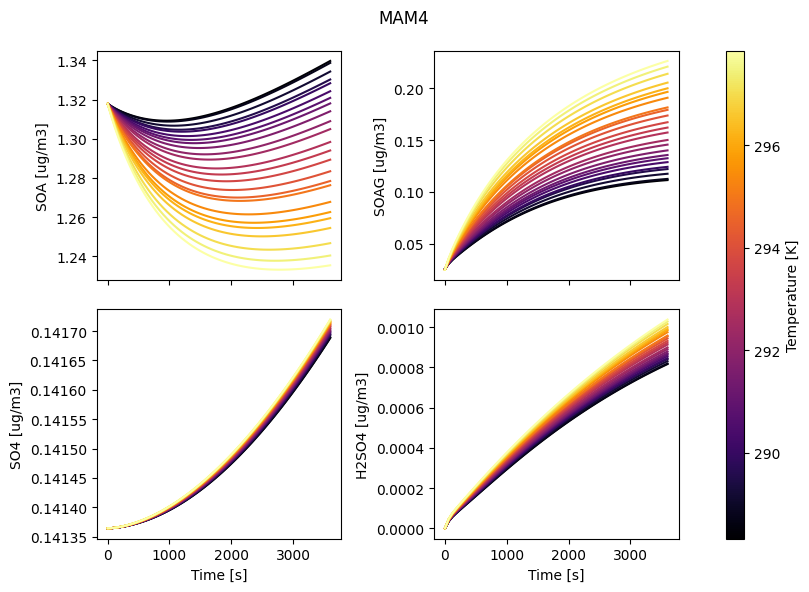

In [27]:
fig, ((ax1,ax2,cax1),(ax3,ax4,cax2)) = plt.subplots(nrows=2, ncols=3, figsize=(8,6), sharex=True, gridspec_kw={'width_ratios':(1,1,0)})

cmap = mpl.colormaps['inferno']
norm = mpl.colors.Normalize(vmin=temps.min(), vmax=temps.max())
c_arr = cmap(np.linspace(0,1,24))

ts = 60.*np.arange(61)
for i in range(24):
    ax1.plot(ts, soa_data[i,:], ls='-', alpha=1, c=c_arr[i,:])
    ax2.plot(ts, soag_data[i,:], ls='-', alpha=1, c=c_arr[i,:])
    ax3.plot(ts, so4_data[i,:], ls='-', alpha=1, c=c_arr[i,:])
    ax4.plot(ts, h2so4_data[i,:], ls='-', alpha=1, c=c_arr[i,:])
ax1.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.get_yaxis().get_major_formatter().set_useOffset(False)
ax3.get_yaxis().get_major_formatter().set_useOffset(False)
ax4.get_yaxis().get_major_formatter().set_useOffset(False)

ax1.set_ylabel('SOA [ug/m3]')
ax2.set_ylabel('SOAG [ug/m3]')
ax3.set_ylabel('SO4 [ug/m3]')
ax4.set_ylabel('H2SO4 [ug/m3]')
ax3.set_xlabel('Time [s]')
ax4.set_xlabel('Time [s]')

plt.suptitle('MAM4')
plt.tight_layout()

cax1.set_visible(False); cax2.set_visible(False)
cax = plt.subplot(1,25,24)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='Temperature [K]', orientation='vertical', pad=1)

## PartMC

In [28]:
# Load output

path_to_pmc_output = '/home/dquevedo/AMBRS/jupyter_notebooks/jupyter_partmc_runs'

def prep(ds):
    X = ds[['gas_mixing_ratio','aero_particle_mass','aero_num_conc']]
    soag_idx = np.where(np.array(X.gas_species.attrs['names'].split(','))=='SOAG')[0]
    soa_idx = np.where(np.array(X.aero_species.attrs['names'].split(','))=='core.mixed.SOA')[0]
    h2so4_idx = np.where(np.array(X.gas_species.attrs['names'].split(','))=='SULF')[0]
    so4_idx = np.where(np.array(X.aero_species.attrs['names'].split(','))=='core.mixed.ASO4')[0]
    Y = X.isel(gas_species=[*soag_idx,*h2so4_idx], aero_species=[*soa_idx,*so4_idx])
    Y['aero_mass_conc'] = Y.aero_particle_mass * Y.aero_num_conc
    return Y.sum('aero_particle').squeeze()
dss = [ xr.open_mfdataset(
            f'{path_to_pmc_output}/{member:0>2}/out/*.nc',
            combine='nested',
            concat_dim='tstep',
            preprocess=prep,
        ).load() for member in range(1,25) ]
ds = xr.concat(dss, dim='member')

In [30]:
# Load perturbed temperatures from ensemble members
temps = []
for i in range(1,25):
    with open(f'{path_to_pmc_output}/{i:0>2}/temp.dat','r') as f:
        temps.append(float(f.readlines()[3][5:]))
temps = np.array(temps)
sort_idxs = np.argsort(temps)

In [31]:
# Convert to ug/m3
to_ugperm3 = lambda MW: 101325. * MW / ( 8.314 * temps[:,None] )

soag_data = (1.e-3 * ds.gas_mixing_ratio.isel(gas_species=0).values * to_ugperm3(12.011))[sort_idxs,:]
soa_data = 1.e9 * ds.aero_mass_conc.isel(aero_species=0).values[sort_idxs,:]

h2so4_data = (1.e-3 * ds.gas_mixing_ratio.isel(gas_species=1).values * to_ugperm3(98.))[sort_idxs,:]
so4_data = 1.e9 * ds.aero_mass_conc.isel(aero_species=1).values[sort_idxs,:]

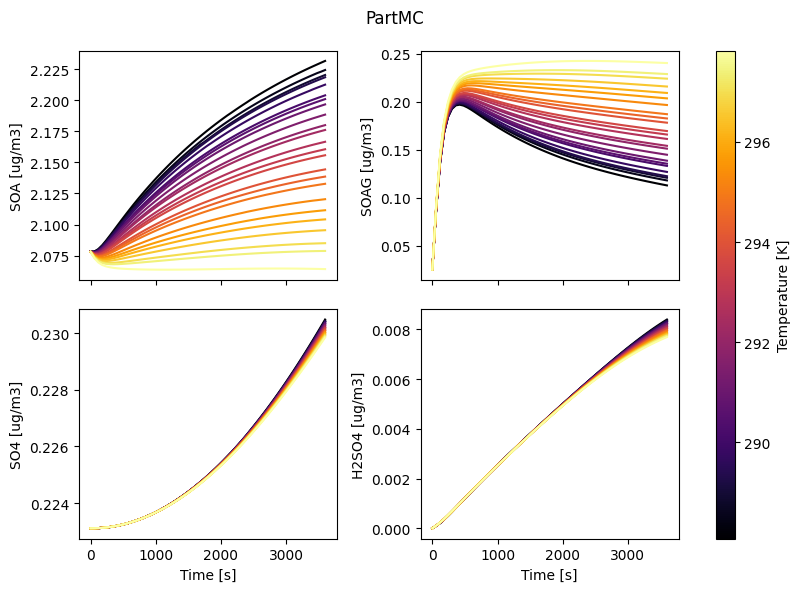

In [32]:
fig, ((ax1,ax2,cax1),(ax3,ax4,cax2)) = plt.subplots(nrows=2, ncols=3, figsize=(8,6), sharex=True, gridspec_kw={'width_ratios':(1,1,0)})

cmap = mpl.colormaps['inferno']
norm = mpl.colors.Normalize(vmin=temps.min(), vmax=temps.max())
c_arr = cmap(np.linspace(0,1,24))

ts = 60.*np.arange(61)
for i in range(24):
    ax1.plot(ts, soa_data[i,:], ls='-', alpha=1, c=c_arr[i,:])
    ax2.plot(ts, soag_data[i,:], ls='-', alpha=1, c=c_arr[i,:])
    ax3.plot(ts, so4_data[i,:], ls='-', alpha=1, c=c_arr[i,:])
    ax4.plot(ts, h2so4_data[i,:], ls='-', alpha=1, c=c_arr[i,:])
ax1.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.get_yaxis().get_major_formatter().set_useOffset(False)
ax3.get_yaxis().get_major_formatter().set_useOffset(False)
ax4.get_yaxis().get_major_formatter().set_useOffset(False)

ax1.set_ylabel('SOA [ug/m3]')
ax2.set_ylabel('SOAG [ug/m3]')
ax3.set_ylabel('SO4 [ug/m3]')
ax4.set_ylabel('H2SO4 [ug/m3]')
ax3.set_xlabel('Time [s]')
ax4.set_xlabel('Time [s]')

plt.suptitle('PartMC')
plt.tight_layout()

cax1.set_visible(False); cax2.set_visible(False)
cax = plt.subplot(1,25,24)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='Temperature [K]', orientation='vertical', pad=1)